Task9. Artificially create more training examples, by applying small transformations (translations, rotations, resizing, etc.) to the original images.

In [38]:
import numpy as np
from scipy.io import loadmat


def standardizeCols(M, mu=None, sigma2=None):
    M = M.astype(float)  # Ensure M is float for precision
    nrows, ncols = M.shape
    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        sigma2[sigma2 < np.finfo(float).eps] = 1  # Avoid division by zero
    S = M - mu  # Subtract mean
    if ncols > 0:
        S = S / sigma2  # Divide by standard deviation
    return S, mu, sigma2


def form_weights(w, nVars, nHidden, nLabels):
    offset = 0
    inputWeights = w[offset:nVars * nHidden[0]].reshape(nVars, nHidden[0])
    offset += nVars * nHidden[0]
    hiddenWeights = []
    for h in range(1, len(nHidden)):
        size = (nHidden[h-1] + 1) * nHidden[h]
        hiddenWeights.append(
            w[offset:offset+size].reshape(nHidden[h-1] + 1, nHidden[h]))
        offset += size
    outputWeights = w[offset:offset + (nHidden[-1] + 1) * nLabels].reshape(nHidden[-1] + 1, nLabels)
    return inputWeights, hiddenWeights, outputWeights


def sech2(x):
    return 1 - np.tanh(x)**2


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)


def cross_entropy_loss(y_pred, y_true):
    # Assuming y_true is 1D array of labels
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    correct_confidences = y_pred[np.arange(len(y_pred)), y_true]
    return -np.log(correct_confidences)

First, we implement functions to apply the transformations (translations, rotations, resizing, etc.) to images. To value the undefined pixels, we utilize bilinear interpolation.

In [39]:
def bilinear_interpolation(img, pos):
    # img: 2-D numpy array
    # pos: position to be interpolated. 1-D numpy array
    m, n = img.shape
    x = min(max(pos[0], 0), m - 1)
    y = min(max(pos[1], 0), n - 1)
    x1, y1 = int(x), int(y)
    x2, y2 = x1 + 1, y1 + 1
    if x2 >= m:
        x2 = x1
    if y2 >= n:
        y2 = y1
    q11, q12, q21, q22 = img[x1, y1], img[x1, y2], img[x2, y1], img[x2, y2]
    if x1 != x2:
        r1 = (x2 - x) / (x2 - x1) * q11 + (x - x1) / (x2 - x1) * q21
        r2 = (x2 - x) / (x2 - x1) * q12 + (x - x1) / (x2 - x1) * q22
    else:
        r1, r2 = q11, q12
    if y1 != y2:
        return (y2 - y) / (y2 - y1) * r1 + (y - y1) / (y2 - y1) * r2
    else:
        return r1

In [40]:
def translation(img, shift):
    height, width = img.shape
    tx, ty = shift

    translated = np.zeros_like(img)
    
    for i in range(height):
        for j in range(width):
            pos = np.array([i - ty, j - tx])
            translated[i, j] = bilinear_interpolation(img, pos)

    return translated

In [41]:
def rotation(img, theta):
    theta_rad = np.deg2rad(theta)
    cos_theta, sin_theta = np.cos(theta_rad), np.sin(theta_rad)

    height, width = img.shape
    rotated = np.zeros_like(img)
    center_y, center_x = height // 2, width // 2

    for i in range(height):
        for j in range(width):
            # Map pixel in the original image to the new image
            y = (i - center_y) * cos_theta + \
                (j - center_x) * sin_theta + center_y
            x = -(i - center_y) * sin_theta + \
                (j - center_x) * cos_theta + center_x
            rotated[i, j] = bilinear_interpolation(img, np.array([y, x]))

    return rotated

In [42]:
def resize(img, scale):
    m, n = img.shape

    # Calculate corresponding position of each pixel in new image
    center = np.array([m, n]) / 2 + 0.5
    pos = np.zeros((m, n, 2))
    for i in range(m):
        for j in range(n):
            pos[i, j] = [(i - center[0]) * scale[0] / m + center[0],
                         (j - center[1]) * scale[1] / n + center[1]]

    # Create new image and apply bilinear interpolation
    new_img = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            new_img[i, j] = bilinear_interpolation(img, pos[i, j])

    return new_img

In [49]:
import numpy as np
from scipy.io import loadmat, savemat

# Load data from a .mat file
data = loadmat('digits.mat')
X = data['X']
y = data['y']

# Set how many images should be added
new_image = 5000

# Calculate how many new images to generate per existing image
N = np.round(new_image / X.shape[0])

id = X.shape[0]

# Copy X and y to avoid modifying original arrays during augmentation
X_augmented = np.copy(X)
y_augmented = np.copy(y)

for i in range(X.shape[0]):
    for j in range(int(N)):
        # Reshape into 16*16 image
        img = np.reshape(X[i, :], (16, 16)) / 255.0

        # Randomly decide one kind of the three types of data augmentation
        type = np.random.randint(0, 3)
        if type == 0:
            trans = 4 * np.random.rand(2) - 2
            img = translation(img, trans)
        elif type == 1:
            theta = 0.6 * np.random.rand() - 0.3
            img = rotation(img, theta)
        elif type == 2:
            scale = np.floor(10 + 3 * np.random.rand(2)).astype(int)
            img = resize(img, scale)

        # Add into training set
        if id >= X_augmented.shape[0]:
            # If new id exceeds current array size, extend the arrays
            X_augmented = np.vstack([X_augmented, np.zeros((1, X.shape[1]))])
            y_augmented = np.vstack([y_augmented, np.zeros((1, y.shape[1]))])

        X_augmented[id, :] = np.floor(255 * img.ravel())
        y_augmented[id, :] = y[i, :]
        id += 1

# Save the new data
savemat('augmentation_digits.mat', {'X': X_augmented, 'y': y_augmented})

In [44]:
def MLPclassificationPredict(w, X, nHidden, nLabels):
    nInstances, nVars = X.shape
    inputWeights, hiddenWeights, outputWeights = form_weights(
        w, nVars, nHidden, nLabels)
    activations = X
    for h in range(len(nHidden)):
        if h == 0:
            preActivation = np.dot(activations, inputWeights)
        else:
            preActivation = np.dot(np.hstack(
                [activations, np.ones((activations.shape[0], 1))]), hiddenWeights[h-1])
        activations = np.tanh(preActivation)
    finalOutput = np.dot(
        np.hstack([activations, np.ones((activations.shape[0], 1))]), outputWeights)
    y_pred = softmax(finalOutput)
    predictions = np.argmax(y_pred, axis=1, keepdims=True)
    return predictions


def MLPclassificationLoss(w, X, y, nHidden, nLabels, reg_lambda, dropout_rate):
    # y is column vector of labels
    nInstances, nVars = X.shape
    inputWeights, hiddenWeights, outputWeights = form_weights(
        w, nVars, nHidden, nLabels)

    activations = [X]
    dropout_masks = []
    for h in range(len(nHidden)):
        if h == 0:
            preActivation = np.dot(activations[-1], inputWeights)
        else:
            preActivation = np.dot(np.hstack(
                [activations[-1], np.ones((activations[-1].shape[0], 1))]), hiddenWeights[h-1])
        a = np.tanh(preActivation)
        # Apply dropout
        if dropout_rate > 0:
            mask = np.random.binomial(
                1, 1 - dropout_rate, size=a.shape) / (1 - dropout_rate)
            a *= mask
            dropout_masks.append(mask)
        activations.append(a)

    finalOutput = np.dot(
        np.hstack([activations[-1], np.ones((activations[-1].shape[0], 1))]), outputWeights)
    yhat = softmax(finalOutput)
    f = np.mean(cross_entropy_loss(yhat, y))  # Cross-entropy loss

    # Add L2 regularization term to the loss function
    total_loss = f + (reg_lambda / 2) * np.sum(w**2)

    # Gradient of the loss with respect to output
    d_out = yhat.copy()
    d_out[np.arange(nInstances), y] -= 1
    gOutput = np.hstack([activations[-1], np.ones((activations[-1].shape[0], 1))]
                        ).T @ d_out + reg_lambda * outputWeights

    gHidden = []
    # Exclude the last row for bias
    delta = d_out @ outputWeights[:-1, :].T * sech2(activations[-1])

    for h in range(len(nHidden) - 1, 0, -1):
        delta *= dropout_masks[h]  # Apply dropout mask to delta
        act_with_bias = np.hstack(
            [activations[h], np.ones((activations[h].shape[0], 1))])
        gHidden.append(act_with_bias.T @ delta +
                       reg_lambda * hiddenWeights[h-1])
        delta = (delta @ hiddenWeights[h-1][:-1, :].T) * sech2(activations[h])

    # Apply dropout mask to delta for the first hidden layer
    delta *= dropout_masks[0]
    gHidden.append(activations[0].T @ delta + reg_lambda * inputWeights)
    gHidden.reverse()

    gradients = [gHidden[0].flatten()]
    for g in gHidden[1:]:
        gradients.append(g.flatten())
    gradients.append(gOutput.flatten())
    g = np.concatenate(gradients)

    return total_loss, g.reshape(-1, 1)

Training iteration = 10000, training error = 0.224500, validation error = 0.150600
Training iteration = 20000, training error = 0.257800, validation error = 0.205200
Training iteration = 30000, training error = 0.218200, validation error = 0.158800
Training iteration = 40000, training error = 0.248500, validation error = 0.203000
Training iteration = 50000, training error = 0.230400, validation error = 0.181000
Training iteration = 60000, training error = 0.216300, validation error = 0.154200
Training iteration = 70000, training error = 0.214800, validation error = 0.164400
Training iteration = 80000, training error = 0.221500, validation error = 0.162400
Training iteration = 90000, training error = 0.234400, validation error = 0.174600
Training iteration = 100000, training error = 0.217800, validation error = 0.149800


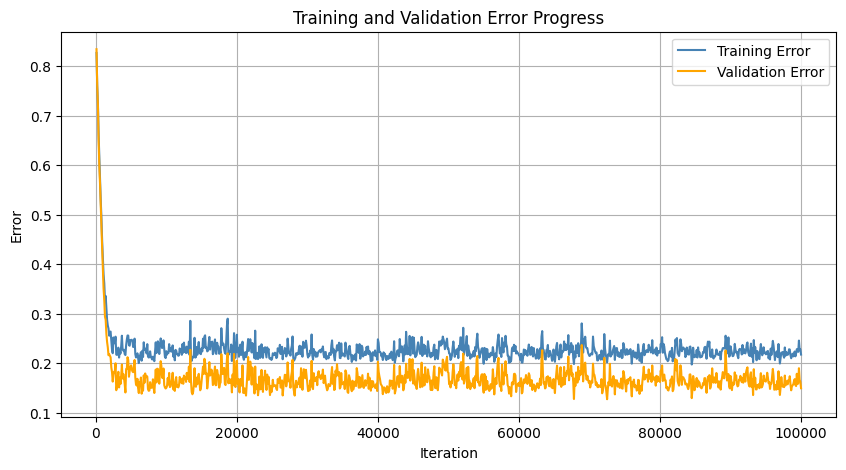

Test error with final model = 0.119000


In [51]:
import matplotlib.pyplot as plt


data = loadmat('digits.mat')
data_new = loadmat('augmentation_digits.mat')
X = data_new['X']
y = data_new['y'].astype(int)
y -= 1  # Convert to 0-based index
yvalid = data['yvalid'] - 1
ytest = data['ytest'] - 1
n, d = X.shape
nLabels = 10
t = data['Xvalid'].shape[0]
t2 = data['Xtest'].shape[0]
X, mu, sigma = standardizeCols(X)
X = np.hstack([np.ones((n, 1)), X])
Xvalid, _, _ = standardizeCols(data['Xvalid'], mu, sigma)
Xvalid = np.hstack([np.ones((t, 1)), Xvalid])
Xtest, _, _ = standardizeCols(data['Xtest'], mu, sigma)
Xtest = np.hstack([np.ones((t2, 1)), Xtest])

nHidden = [50]
d += 1

nParams = d * nHidden[0] + sum((nHidden[h-1] + 1) * nHidden[h] for h in range(1, len(nHidden))) + (nHidden[-1] + 1) * nLabels
maxIter = 100000
initialStepSize = 0.001
decayRate = 1e-6
momentum = 0.9
reg_lambda = 0.125
dropout_rate = 0.5

w = np.random.randn(nParams, 1)
w_diff = np.zeros_like(w)   
best_w = np.copy(w)
best_validation_error = float('inf')

train_errors = []
valid_errors = []
iterations = []

for iter in range(0, maxIter):
    stepSize = initialStepSize * (1 / (1 + decayRate * iter))
    if (iter + 1) % (maxIter // 1000) == 0:
        yhat1 = MLPclassificationPredict(w, X, nHidden, nLabels)
        train_error = np.mean(yhat1 != y.reshape(-1, 1))
        yhat = MLPclassificationPredict(w, Xvalid, nHidden, nLabels)
        validation_error = np.mean(yhat != yvalid)
        train_errors.append(train_error)
        valid_errors.append(validation_error)
        iterations.append(iter + 1)
        if (iter + 1) % (maxIter // 10) == 0:
            print(f'Training iteration = {iter + 1}, training error = {train_error:.6f}, validation error = {validation_error:.6f}')

        if validation_error < best_validation_error:
            best_validation_error = validation_error
            best_w = np.copy(w)
    
    i = np.random.randint(n)
    _, g = MLPclassificationLoss(
        w, X[i:i+1], y[i:i+1], nHidden, nLabels, reg_lambda, dropout_rate)
    w_diff = momentum * w_diff - stepSize * g
    w += w_diff

# Plot training and validation error progress
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_errors, label='Training Error', color='steelblue')
plt.plot(iterations, valid_errors, label='Validation Error', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Training and Validation Error Progress')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate test error
yhat = MLPclassificationPredict(best_w, Xtest, nHidden, nLabels)
test_error = np.mean(yhat != ytest)
print(f'Test error with final model = {test_error:.6f}')